In [1]:
import jax
from jax import random, Array
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import *

from gp import mk_cov_blk, kern_blk, k, cholesky_inv, PlotContext, plot_deriv_dataset, create_toy_deriv_dataset

key = random.PRNGKey(42)  # Create a random key                        

# Variational GPwDs (VGPwDs)

In this notebook, we explore extending VGPs to the setting with derivatives, i.e., a Variational GPwD (VGPwD). As usual, we'll use a toy dataset to illustrate the main ideas.

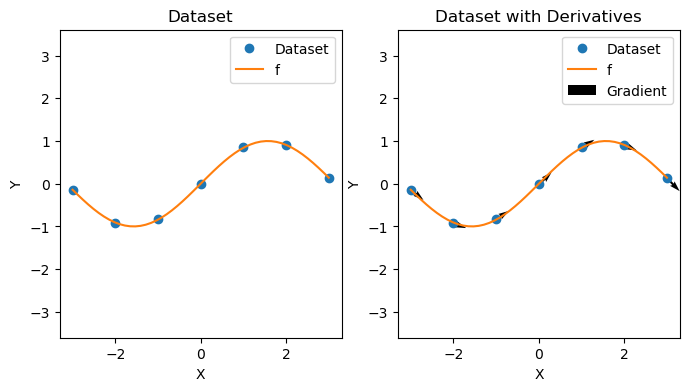

In [2]:
f = lambda x: jnp.sin(x)
xs, ys, gs, Sigma = create_toy_deriv_dataset(f, key)
plot_deriv_dataset(xs, ys, gs, f)

## VGPwD: Posterior Approximation

The VGPwD [1] applies the same principles of variational inference to approximate the posterior $p(f, \nabla f, u, \nabla u | y, g)$ as the VGP did for the posterior $p(f, u | y)$. Since a GPwD is a GP with a modified kernel function, we can use the posterior predictive of a VGP with $K$ replaced with $\tilde{K}$. This results in the posterior predictive
\begin{align}
q(f_* | y) & = \mathcal{N}(\tilde{K}_{*z}C^{-1}\tilde{K}_{zx}\Sigma^{-1}y, \tilde{K}_{* *} - \tilde{K}_{*z}(\tilde{K}_{zz}^{-1} - C^{-1})^{-1}\tilde{K}_{z*}
\end{align}
where $C = \tilde{K}_{zz} + \tilde{K}_{zx}\Sigma^{-1} \tilde{K}_{xz}$.

In [3]:
def fit_vgpwd(k: Callable, Sigma: Array, xs: Array, ys: Array, zs: Array):
    # Compute covariances
    tilde_K_zz = mk_cov_blk(k, zs, zs)
    tilde_K_xz = mk_cov_blk(k, xs, zs)
    tilde_K_zx = tilde_K_xz.transpose()
    tilde_K_zx = tilde_K_xz.transpose()
    tilde_K_zz_inv = cholesky_inv(tilde_K_zz)
    
    # Perform approximations
    Sigma_inv = jnp.diag(jnp.tile(1/jnp.diag(Sigma), len(xs)))
    C = tilde_K_zz + tilde_K_zx @ Sigma_inv @ tilde_K_xz
    C_inv = cholesky_inv(C)
    
    alpha = C_inv @ tilde_K_zx @ Sigma_inv @ ys
    cov = tilde_K_zz_inv - C_inv
    
    return alpha, cov

In [4]:
def vgpwd_post_pred_mean(k: Callable, zs: Array, alpha: Array, x_star: Array) -> Array:
    """Posterior predictive mean.
    """
    K_star_z = jnp.concatenate([kern_blk(k, x_star, z) for z in zs], axis=1)
    return K_star_z @ alpha


def vgpwd_post_pred_cov(k: Callable, zs: Array, cov: Array, x_star: Array) -> Array:
    """Posterior predictive covariance.
    """
    K_star_star = kern_blk(k, x_star, x_star)
    K_star_z = jnp.concatenate([kern_blk(k, x_star, z) for z in zs], axis=1)
    return K_star_star - K_star_z @ cov @ K_star_z.transpose()

### VGPwD: inducing points are training set

We visualize a VGPwD where we make no approximation first.

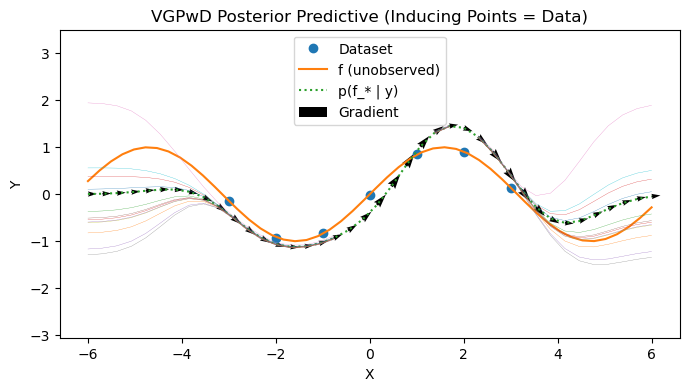

In [5]:
hs = jnp.concatenate([jnp.concatenate([y, g]) for y, g in zip(ys, gs)])
zs_all_xs = xs 
alpha_beta_all_xs, cov_all_xs  = fit_vgpwd(k, Sigma, xs, hs, zs_all_xs)

# Create posterior prediction
test_xs = jnp.linspace(-6, 6, 40).reshape(-1, 1)
post_tfs = [vgpwd_post_pred_mean(k, zs_all_xs, alpha_beta_all_xs, x_star) for x_star in test_xs]
post_ys = [h[0] for h in post_tfs]
post_gs = [h[1:] for h in post_tfs]

post_mean = jax.vmap(lambda x_star: vgpwd_post_pred_mean(k, zs_all_xs, alpha_beta_all_xs, x_star))(test_xs)
post_cov = jax.vmap(lambda x_star: vgpwd_post_pred_cov(k, zs_all_xs, cov_all_xs, x_star), out_axes=0)(test_xs)
post_cov_ys = [random.normal(key, shape=(12,)) * jnp.sqrt(post_cov[i][0][0]) + post_mean[i][0] for i in range(len(test_xs))]

# Plot
with PlotContext(title="VGPwD Posterior Predictive (Inducing Points = Data)", xlabel="X", ylabel="Y") as ax:
    # Plot dataset
    plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    plt.plot(jnp.linspace(-6, 6), f(jnp.linspace(-6, 6)), label="f (unobserved)")
    
    # Plot posterior values
    plt.plot(test_xs, post_ys, label="p(f_* | y)", linestyle="dotted")
    plt.plot(test_xs, post_cov_ys, linewidth=0.2)
    
    # Plot posterior gradients
    origin = jnp.array([test_xs.reshape(-1), post_ys])
    plt.quiver(*origin, jnp.ones(len(test_xs)), post_gs, label="Gradient", width=0.01, scale=70)

### VGPwD: inducing points are not training set

We now visualize a VGPwD where we choose a subset of the points to be a subset of the training data. It is possible to consider jointly learning the inducing points as well.

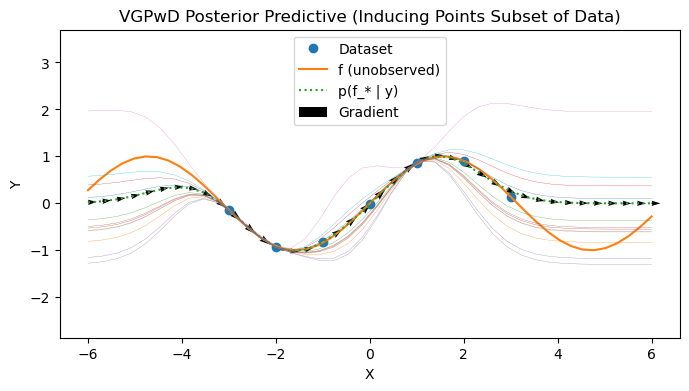

In [6]:
zs_p = jnp.array([xs[0], xs[1], xs[-3]])
alpha_beta_p, cov_p  = fit_vgpwd(k, Sigma, xs, hs, zs_p)

# Create posterior prediction
test_xs = jnp.linspace(-6, 6, 40).reshape(-1, 1)
post_tfs = [vgpwd_post_pred_mean(k, zs_p, alpha_beta_p, x_star) for x_star in test_xs]
post_ys = [h[0] for h in post_tfs]
post_gs = [h[1:] for h in post_tfs]

post_mean = jax.vmap(lambda x_star: vgpwd_post_pred_mean(k, zs_p, alpha_beta_p, x_star))(test_xs)
post_cov = jax.vmap(lambda x_star: vgpwd_post_pred_cov(k, zs_p, cov_p, x_star), out_axes=0)(test_xs)
post_cov_ys = [random.normal(key, shape=(12,)) * jnp.sqrt(post_cov[i][0][0]) + post_mean[i][0] for i in range(len(test_xs))]

# Plot
with PlotContext(title="VGPwD Posterior Predictive (Inducing Points Subset of Data)", xlabel="X", ylabel="Y") as ax:
    # Plot dataset
    plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    plt.plot(jnp.linspace(-6, 6), f(jnp.linspace(-6, 6)), label="f (unobserved)")

    # Plot posterior values
    plt.plot(test_xs, post_ys, label="p(f_* | y)", linestyle="dotted")
    plt.plot(test_xs, post_cov_ys, linewidth=0.2)
    
    # Plot posterior gradients
    origin = jnp.array([test_xs.reshape(-1), post_ys])
    plt.quiver(*origin, jnp.ones(len(test_xs)), post_gs, label="Gradient", width=0.01, scale=70)

## References

1. (Scaling Gaussian Processes with Derivative
Information Using Variational Inference)[https://proceedings.neurips.cc/paper/2021/file/32bbf7b2bc4ed14eb1e9c2580056a989-Paper.pdf]